In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.datasets import make_regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from scipy.stats import norm
from tqdm.notebook import tqdm
from sklearn.base import clone

# Acquisition functions

In [2]:
# Prediction intervals for random forests
'''
def pred_ints(model, X, percentile=95):
    means = []
    stds = []
    for x in range(len(X)):
        preds = []
        for pred in model.estimators_:
            preds.append(pred.predict(X[x].reshape(1,-1))[0])
        means.append(np.mean(preds))
        stds.append(np.std(preds))
    return means, stds
'''


def pred_ints(model,X_list):
    est_num = len(model.estimators_)
    preds = np.zeros((est_num,len(X_list)))
    for i,pred in enumerate(model.estimators_):
        preds[i] = pred.predict(X_list)

    means = np.mean(preds,axis=0)
    std = np.std(preds,axis=0)
    return means, std**2


def pred_ints_mod(model,X_list):
    est_num = len(model.estimators_)
    preds = np.zeros((est_num,len(X_list)))
    for i,pred in enumerate(model.estimators_):
        preds[i] = pred.predict(X_list)

    means = np.mean(preds,axis=0)
    std = np.std(preds,axis=0)
    return means, std

In [3]:
def FunRandom(x,model,fstar):
    return np.random.uniform(size=len(x))

def Greedy(x_list,model,fstar):
    return model.predict(x_list)

def UCB(x_list,model,fstar,beta=2):
    mu,sigma = pred_ints(model,x_list)
    return mu+beta*sigma

def gamma(x_list,model,fstar,epsilon=0.01):
    return model.predict(x_list)-fstar+epsilon

def z(x_list,model,fstar):
    mu, sigma = pred_ints(model,x_list)
    return gamma(x_list,model,fstar)/sigma

def EI(x_list,model, fstar):
    mu, sigma = pred_ints(model,x_list)
    zl = z(x_list,model,fstar)
    eis = np.zeros_like(mu)
    gl = gamma(x_list,model,fstar)
    for i,gam,zz,ss in zip(list(range(len(mu))),gl,zl,sigma):
        if(ss>0):
            eis[i] = gam*norm.cdf(zz)+ss*norm.pdf(zz)
        else:
            eis[i] = gam
    return eis
    
def PI(x_list,model,fstar):
    mu,sigma = pred_ints(model,x_list)
    zl = z(x_list,model,fstar)
    gam = gamma(x_list,model,fstar)
    ppi = np.zeros_like(mu)
    for i,gg,ss,zz in zip(list(range(len(x_list))),gam,sigma,zl):
        if(ss>0):
            ppi[i] = norm.cdf(zz)
        else:
            if(gg>0):
                ppi[i]=1
            else:
                ppi[i]=0
    return ppi

def UCB_mod(x_list,model,fstar,beta=2):
    mu,sigma = pred_ints_mod(model,x_list)
    return mu+beta*sigma

def EI_mod(x_list,model, fstar):
    mu, sigma = pred_ints_mod(model,x_list)
    zl = z(x_list,model,fstar)
    eis = np.zeros_like(mu)
    gl = gamma(x_list,model,fstar)
    for i,gam,zz,ss in zip(list(range(len(mu))),gl,zl,sigma):
        if(ss>0):
            eis[i] = gam*norm.cdf(zz)+ss*norm.pdf(zz)
        else:
            eis[i] = gam
    return eis
    
def PI_mod(x_list,model,fstar):
    mu,sigma = pred_ints_mod(model,x_list)
    zl = z(x_list,model,fstar)
    gam = gamma(x_list,model,fstar)
    ppi = np.zeros_like(mu)
    for i,gg,ss,zz in zip(list(range(len(x_list))),gam,sigma,zl):
        if(ss>0):
            ppi[i] = norm.cdf(zz)
        else:
            if(gg>0):
                ppi[i]=1
            else:
                ppi[i]=0
    return ppi

In [4]:
# Number of actives and true actives

def actives_counter(model,X_sample,y_trues,fstar):
    y_sample = model.predict(X_sample)
    number_act = 0
    number_t_act = 0
    for y,yt in zip(y_sample,y_trues):
        if(y>fstar):
            number_act+=1
        if(y>fstar and yt>fstar):
            number_t_act += 1
        
    return number_act, number_t_act

In [5]:
seeds = [658, 682, 533, 27, 889, 224, 205, 338, 559, 163]
X_train, y_train = make_regression(n_samples=5000,n_features=10,n_informative=5,n_targets=1,noise=0.0)
fstar = np.percentile(y_train,90)
NEP = 30
Bsize = 100

In [6]:
a = y_train.copy()
a.sort()
ffstar = a[int(len(a)*(100-10)/100)]

In [22]:
5000/(1-0.33)

7462.68656716418

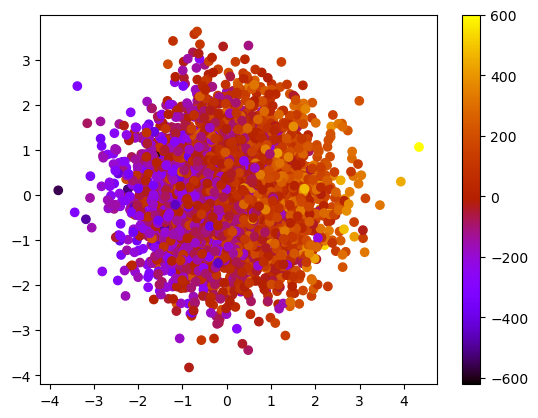

In [8]:
im = plt.scatter(X_train[:,0],X_train[:,1],c=y_train,cmap='gnuplot')
plt.colorbar(im)

# Active learning part

In [9]:
def single_run(acq_fun,fstar,batchsize,seed,init_size=100,data_set_size=5000):
    #print('Single run example')
    indices = list(range(data_set_size))
    np.random.shuffle(indices)
    X_init = X_train[indices[:init_size]]
    y_init = y_train[indices[:init_size]]

    # Acq function candidates
    X_cands_ac = X_train[indices[init_size:]]
    y_cands_ac = y_train[indices[init_size:]]

    # Surrogate Model
    model_ac = RandomForestRegressor(100, n_jobs=-2,random_state=seed)
    model_ac.fit(X_init,y_init)

    X_init_ac = X_init.copy()
    y_init_ac = y_init.copy()

    A_act_ac = []
    A_t_act_ac = []
    A_act_ac.append(0)
    A_t_act_ac.append(0)

    # Looping over different episodes 30
    for _ in tqdm(list(range(NEP)),desc='Batches'):
        # Initialize the list on the acq functions
        
        #AC_list = []
        #print('Initializing episode')
        #for x in X_cands_ac:
        #    AC_list.append(acq_fun(x,model_ac,fstar))
        
        AC_list = acq_fun(X_cands_ac,model_ac,fstar)

        # Append to the training and remove from candidates.
        X_recommend = X_cands_ac[np.argsort(AC_list)[-1*batchsize:]]
        y_recommend = y_cands_ac[np.argsort(AC_list)[-1*batchsize:]]
        X_init_ac = np.append(X_init_ac,X_recommend,axis=0)
        y_init_ac = np.append(y_init_ac,y_recommend,axis=0)
        X_cands_ac = np.delete(X_cands_ac,np.argsort(AC_list)[-1*batchsize:],axis=0)
        y_cands_ac = np.delete(y_cands_ac,np.argsort(AC_list)[-1*batchsize:],axis=0)
    
        # Refit the models
        model_ac.fit(X_init_ac,y_init_ac)

        # And add the accumulated hits
        v1, v2 = actives_counter(model_ac,X_recommend,y_recommend,fstar)
        if(len(A_act_ac)==0):
            A_act_ac.append(v1)
            A_t_act_ac.append(v2)
        else:
            A_act_ac.append(v1+A_act_ac[-1])
            A_t_act_ac.append(v2+A_t_act_ac[-1])
    
    return A_act_ac, A_t_act_ac

In [10]:
# Doing the 10 repetitions for the random ac_funciton

Ar = []
Ar_t = []

for i in tqdm(list(range(NEP)),desc='Episodes'):
    #print('Attempt %i'%i)
    v1,v2 = single_run(FunRandom,fstar,Bsize,seeds[NEP-i-1])
    Ar.append(v1)
    Ar_t.append(v2)

Episodes:   0%|          | 0/10 [00:00<?, ?it/s]

Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Batches:   0%|          | 0/10 [00:00<?, ?it/s]

In [11]:
Ar_g = []
Ar_t_g = []

for i in tqdm(list(range(NEP)),desc='Episodes'):
    #print('Attempt %i'%i)
    v1,v2 = single_run(Greedy,fstar,Bsize,seeds[NEP-i-1])
    Ar_g.append(v1)
    Ar_t_g.append(v2)

Episodes:   0%|          | 0/10 [00:00<?, ?it/s]

Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Batches:   0%|          | 0/10 [00:00<?, ?it/s]

In [12]:
Ar_pi = []
Ar_t_pi = []

for i in tqdm(list(range(NEP)),desc='Episodes'):
    #print('Attempt %i'%i)
    v1,v2 = single_run(PI,fstar,Bsize,seeds[NEP-i-1])
    Ar_pi.append(v1)
    Ar_t_pi.append(v2)

Episodes:   0%|          | 0/10 [00:00<?, ?it/s]

Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Batches:   0%|          | 0/10 [00:00<?, ?it/s]

In [13]:
Ar_ei = []
Ar_t_ei = []

for i in tqdm(list(range(NEP)),desc='Episodes'):
    #print('Attempt %i'%i)
    v1,v2 = single_run(EI,fstar,Bsize,seeds[NEP-i-1])
    Ar_ei.append(v1)
    Ar_t_ei.append(v2)

Episodes:   0%|          | 0/10 [00:00<?, ?it/s]

Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Batches:   0%|          | 0/10 [00:00<?, ?it/s]

In [14]:
Ar_ucb = []
Ar_t_ucb = []

for i in tqdm(list(range(NEP)),desc='Episodes'):
    #print('Attempt %i'%i)
    v1,v2 = single_run(UCB,fstar,Bsize,seeds[NEP-i-1])
    Ar_ucb.append(v1)
    Ar_t_ucb.append(v2)

Episodes:   0%|          | 0/10 [00:00<?, ?it/s]

Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Batches:   0%|          | 0/10 [00:00<?, ?it/s]

In [15]:
Ar_ucb_mod = []
Ar_t_ucb_mod = []

for i in tqdm(list(range(NEP)),desc='Episodes'):
    #print('Attempt %i'%i)
    v1,v2 = single_run(UCB_mod,fstar,Bsize,seeds[NEP-i-1])
    Ar_ucb_mod.append(v1)
    Ar_t_ucb_mod.append(v2)

Episodes:   0%|          | 0/10 [00:00<?, ?it/s]

Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Batches:   0%|          | 0/10 [00:00<?, ?it/s]

In [16]:
Ar_ei_mod = []
Ar_t_ei_mod = []

for i in tqdm(list(range(NEP)),desc='Episodes'):
    #print('Attempt %i'%i)
    v1,v2 = single_run(EI_mod,fstar,Bsize,seeds[NEP-i-1])
    Ar_ei_mod.append(v1)
    Ar_t_ei_mod.append(v2)

Episodes:   0%|          | 0/10 [00:00<?, ?it/s]

Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Batches:   0%|          | 0/10 [00:00<?, ?it/s]

In [17]:
Ar_pi_mod = []
Ar_t_pi_mod = []

for i in tqdm(list(range(NEP)),desc='Episodes'):
    #print('Attempt %i'%i)
    v1,v2 = single_run(PI_mod,fstar,Bsize,seeds[NEP-i-1])
    Ar_pi_mod.append(v1)
    Ar_t_pi_mod.append(v2)

Episodes:   0%|          | 0/10 [00:00<?, ?it/s]

Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Batches:   0%|          | 0/10 [00:00<?, ?it/s]

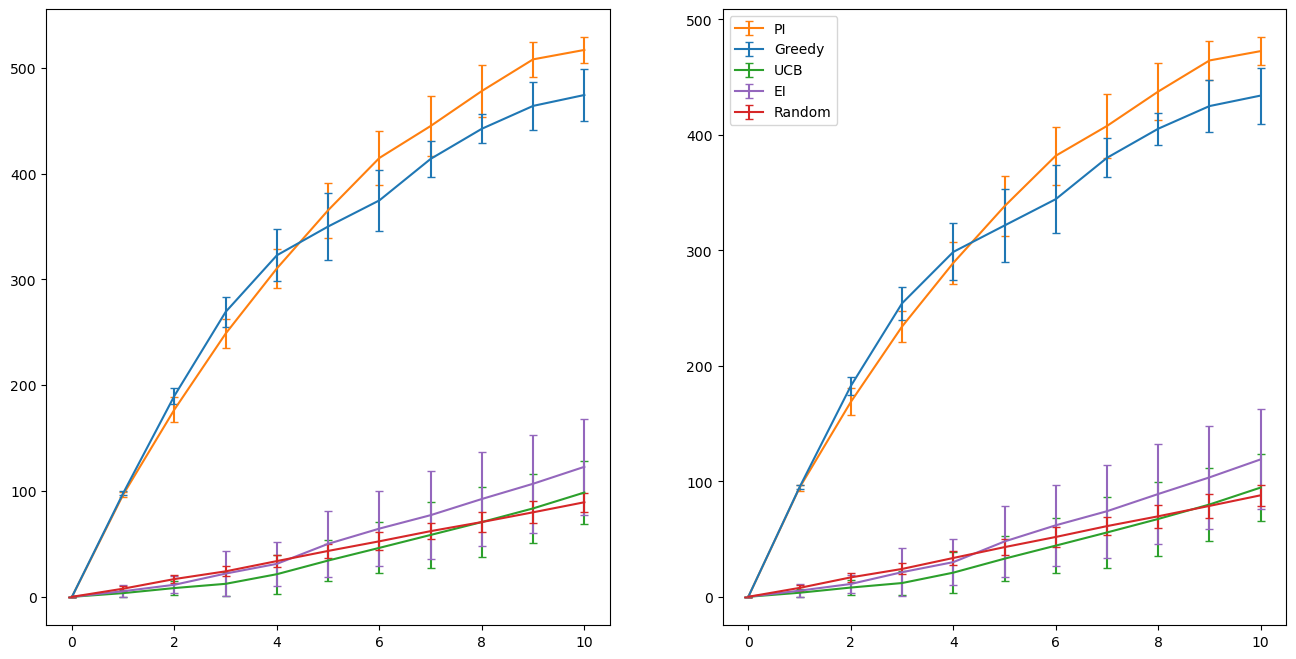

In [18]:
fig, ax = plt.subplots(1,2,figsize=(16,8))

ax[0].errorbar(x=range(NEP+1),y=np.mean(Ar_pi,axis=0),yerr=np.std(Ar_pi,axis=0),capsize=3,color='C1',label='PI')
ax[0].errorbar(x=range(NEP+1),y=np.mean(Ar_g,axis=0),yerr=np.std(Ar_g,axis=0),capsize=3,color='C0',label='Greedy')
ax[0].errorbar(x=range(NEP+1),y=np.mean(Ar_ucb,axis=0),yerr=np.std(Ar_ucb,axis=0),capsize=3,color='C2',label='UCB')
ax[0].errorbar(x=range(NEP+1),y=np.mean(Ar_ei,axis=0),yerr=np.std(Ar_ei,axis=0),capsize=3,color='C4',label='EI')
ax[0].errorbar(x=range(NEP+1),y=np.mean(Ar,axis=0),yerr=np.std(Ar,axis=0),capsize=3,color='C3',label='Random')

ax[1].errorbar(x=range(NEP+1),y=np.mean(Ar_t_pi,axis=0),yerr=np.std(Ar_pi,axis=0),capsize=3,color='C1',label='PI')
ax[1].errorbar(x=range(NEP+1),y=np.mean(Ar_t_g,axis=0),yerr=np.std(Ar_g,axis=0),capsize=3,color='C0',label='Greedy')
ax[1].errorbar(x=range(NEP+1),y=np.mean(Ar_t_ucb,axis=0),yerr=np.std(Ar_t_ucb,axis=0),capsize=3,color='C2',label='UCB')
ax[1].errorbar(x=range(NEP+1),y=np.mean(Ar_t_ei,axis=0),yerr=np.std(Ar_t_ei,axis=0),capsize=3,color='C4',label='EI')
ax[1].errorbar(x=range(NEP+1),y=np.mean(Ar_t,axis=0),yerr=np.std(Ar,axis=0),capsize=3,color='C3',label='Random')
ax[1].legend(loc=0)



Text(0.5, 0, 'Batch')

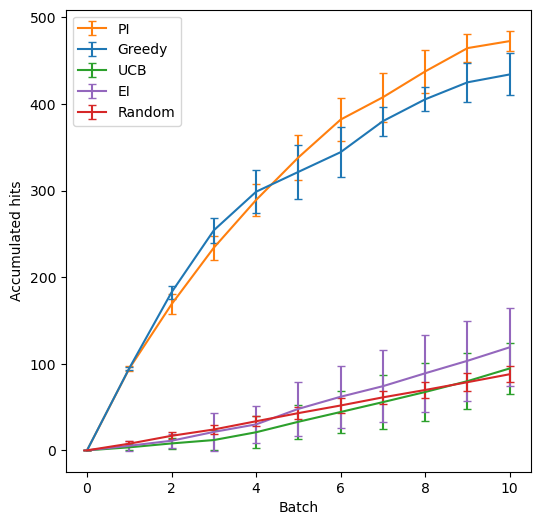

In [52]:
fig, ax = plt.subplots(1,1,figsize=(6,6))

ax.errorbar(x=range(NEP+1),y=np.mean(Ar_t_pi,axis=0),yerr=np.std(Ar_pi,axis=0),capsize=3,color='C1',label='PI')
ax.errorbar(x=range(NEP+1),y=np.mean(Ar_t_g,axis=0),yerr=np.std(Ar_g,axis=0),capsize=3,color='C0',label='Greedy')
ax.errorbar(x=range(NEP+1),y=np.mean(Ar_t_ucb,axis=0),yerr=np.std(Ar_ucb,axis=0),capsize=3,color='C2',label='UCB')
ax.errorbar(x=range(NEP+1),y=np.mean(Ar_t_ei,axis=0),yerr=np.std(Ar_ei,axis=0),capsize=3,color='C4',label='EI')
ax.errorbar(x=range(NEP+1),y=np.mean(Ar_t,axis=0),yerr=np.std(Ar,axis=0),capsize=3,color='C3',label='Random')

ax.legend(loc=0)

ax.set_ylabel('Accumulated hits')
ax.set_xlabel('Batch')

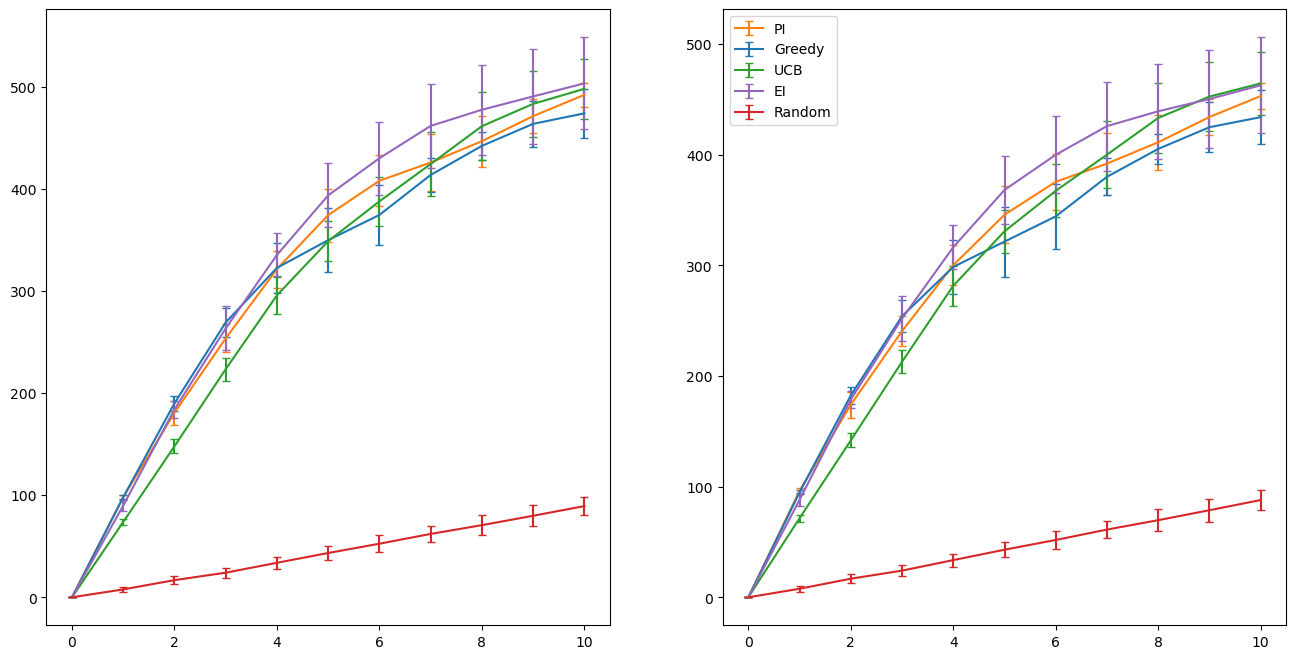

In [19]:
fig, ax = plt.subplots(1,2,figsize=(16,8))

ax[0].errorbar(x=range(NEP+1),y=np.mean(Ar_pi_mod,axis=0),yerr=np.std(Ar_pi,axis=0),capsize=3,color='C1',label='PI')
ax[0].errorbar(x=range(NEP+1),y=np.mean(Ar_g,axis=0),yerr=np.std(Ar_g,axis=0),capsize=3,color='C0',label='Greedy')
ax[0].errorbar(x=range(NEP+1),y=np.mean(Ar_ucb_mod,axis=0),yerr=np.std(Ar_ucb,axis=0),capsize=3,color='C2',label='UCB')
ax[0].errorbar(x=range(NEP+1),y=np.mean(Ar_ei_mod,axis=0),yerr=np.std(Ar_ei,axis=0),capsize=3,color='C4',label='EI')
ax[0].errorbar(x=range(NEP+1),y=np.mean(Ar,axis=0),yerr=np.std(Ar,axis=0),capsize=3,color='C3',label='Random')

ax[1].errorbar(x=range(NEP+1),y=np.mean(Ar_t_pi_mod,axis=0),yerr=np.std(Ar_pi,axis=0),capsize=3,color='C1',label='PI')
ax[1].errorbar(x=range(NEP+1),y=np.mean(Ar_t_g,axis=0),yerr=np.std(Ar_g,axis=0),capsize=3,color='C0',label='Greedy')
ax[1].errorbar(x=range(NEP+1),y=np.mean(Ar_t_ucb_mod,axis=0),yerr=np.std(Ar_t_ucb,axis=0),capsize=3,color='C2',label='UCB')
ax[1].errorbar(x=range(NEP+1),y=np.mean(Ar_t_ei_mod,axis=0),yerr=np.std(Ar_t_ei,axis=0),capsize=3,color='C4',label='EI')
ax[1].errorbar(x=range(NEP+1),y=np.mean(Ar_t,axis=0),yerr=np.std(Ar,axis=0),capsize=3,color='C3',label='Random')
ax[1].legend(loc=0)


Text(0.5, 0, 'Batch')

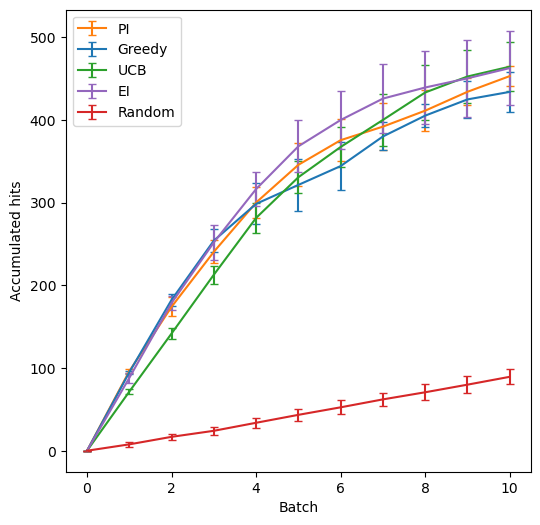

In [53]:
fig, ax = plt.subplots(1,1,figsize=(6,6))

ax.errorbar(x=range(NEP+1),y=np.mean(Ar_t_pi_mod,axis=0),yerr=np.std(Ar_pi,axis=0),capsize=3,color='C1',label='PI')
ax.errorbar(x=range(NEP+1),y=np.mean(Ar_t_g,axis=0),yerr=np.std(Ar_g,axis=0),capsize=3,color='C0',label='Greedy')
ax.errorbar(x=range(NEP+1),y=np.mean(Ar_t_ucb_mod,axis=0),yerr=np.std(Ar_ucb,axis=0),capsize=3,color='C2',label='UCB')
ax.errorbar(x=range(NEP+1),y=np.mean(Ar_t_ei_mod,axis=0),yerr=np.std(Ar_ei,axis=0),capsize=3,color='C4',label='EI')
ax.errorbar(x=range(NEP+1),y=np.mean(Ar,axis=0),yerr=np.std(Ar,axis=0),capsize=3,color='C3',label='Random')

ax.legend(loc=0)
ax.set_ylabel('Accumulated hits')
ax.set_xlabel('Batch')

In [5]:
ax.errorbar(x=range(NEP+1),y=np.mean(Ar_t_pi_mod,axis=0),yerr=np.std(Ar_pi,axis=0),capsize=3,color='C1',label='PI')
ax.errorbar(x=range(NEP+1),y=np.mean(Ar_t_pi,axis=0),yerr=np.std(Ar_pi,axis=0),capsize=3,color='C1',label='PI')

NameError: name 'ax' is not defined

# Using Q-learning

In [43]:
import numdifftools as dif
class SingleLayer():

    def __init__(self,dim_in: int, dim_l: int, dim_o: int,th: float,alpha:float=1e-4,gamma:float=0.2):
        if(len(th)==dim_in*dim_l+dim_l+dim_l*dim_o+dim_o):
            self.alpha = alpha
            self.gamma = gamma
            self.dim_in = dim_in
            self.dim_l = dim_l
            self.dim_o = dim_o
            self.th = th
            self.Mil = th[:dim_in*dim_l].reshape(dim_l,dim_in)
            self.Mlo = th[dim_l*dim_in+dim_l:dim_l*dim_in+dim_l+dim_l*dim_o].reshape(dim_o,dim_l)
            self.bl = np.reshape(th[dim_in*dim_l:dim_in*dim_l+dim_l],(-1,1))
            self.bo = np.reshape(th[dim_l*dim_in+dim_l+dim_l*dim_o:],(-1,1))
            self.loss = 1
            self.loss_curve = []
        else:
            raise ValueError("Incorrect dimensions of single layer")
    
    def update_params(self,th_new):
        if(len(th_new)==self.dim_in*self.dim_l+self.dim_l+self.dim_l*self.dim_o+self.dim_o):
            self.th = th_new
            self.Mil = th_new[:self.dim_in*self.dim_l].reshape(self.dim_l,self.dim_in)
            self.Mlo = th_new[self.dim_l*self.dim_in+self.dim_l:
                self.dim_l*self.dim_in+self.dim_l+self.dim_l*self.dim_o].reshape(self.dim_o,self.dim_l)
            self.bl = np.reshape(th_new[self.dim_in*self.dim_l:self.dim_in*self.dim_l+self.dim_l],(-1,1))
            self.bo = np.reshape(th_new[self.dim_l*self.dim_in+self.dim_l+self.dim_l*self.dim_o:],(-1,1))
        else:
            raise ValueError("Incorrect dimensions when updating params")
        
    def predict(self,x):
        if(len(x)==self.dim_in):
            l = np.maximum(self.Mil@x.reshape(-1,1)+self.bl,np.zeros(self.dim_l).reshape(-1,1))
            return np.maximum(self.Mlo@l+self.bo,np.zeros(self.dim_o).reshape(-1,1))
        else:
            raise ValueError("Incorrect input dimension")
    
    def predict_th(self,th_new,x):
        Mil = th_new[:self.dim_in*self.dim_l].reshape(self.dim_l,self.dim_in)
        Mlo = th_new[self.dim_l*self.dim_in+self.dim_l:
            self.dim_l*self.dim_in+self.dim_l+self.dim_l*self.dim_o].reshape(self.dim_o,self.dim_l)
        bl = np.reshape(th_new[self.dim_in*self.dim_l:self.dim_in*self.dim_l+self.dim_l],(-1,1))
        bo = np.reshape(th_new[self.dim_l*self.dim_in+self.dim_l+self.dim_l*self.dim_o:],(-1,1))
        l = np.maximum(Mil@x.reshape(-1,1)+bl,np.zeros(self.dim_l).reshape(-1,1))
        #return np.maximum(Mlo@l+bo,np.zeros(self.dim_o).reshape(-1,1))
        return Mlo@l+bo
        
    def y(self,r,x):
        return r+self.gamma*max(self.predict(x))
        
    def Loss(self,th,b):
        l = 0
        s,a,r,sp = np.array(b[:self.dim_in]),b[self.dim_in],\
                    b[self.dim_in+1],np.array(b[self.dim_in+2:])
        l += (self.y(r,sp)-self.predict_th(th,s)[int(a)])**2
        return l[0]
    
    def SGD_step(self, batch):
        for b in batch:
            f = lambda yy: self.Loss(yy,b)
            grad = dif.Gradient(f)
            th = self.th - self.alpha * grad(self.th)
            self.update_params(th)
        loss = 0 
        for b in batch:
            loss += self.Loss(self.th,b)
        self.loss = loss/len(batch)
        self.loss_curve.append(self.loss)
        return None

In [44]:
import DeepQLearner as dql

# Greedy sampling function on feature space (just distance to nearest neighboor)
def GS_x(x,x_list):
    distances = np.zeros_like(x_list)

    for ii,xx in enumerate(x_list):
        distances[ii] = np.sqrt(np.sum((x-xx)**2))
    
    return np.min(distances)

def GS_y(x,y_init,model):
    Ypreds = model.predict([x])
    distances =  np.zeros_like(y_init)
    for ii, xx in enumerate(y_init):
        distances[ii] = np.abs(Ypreds-xx)
    return np.min(distances)

def state(model,cand,pool_xs,pool_vals):
    gsx = GS_x(cand,pool_xs)
    gsy = GS_y(cand,pool_vals,model)
    return np.array([*cand,gsx,gsy])

learner = SingleLayer(12,128,2,np.random.random(size=(12*128+128+128*2+2)),alpha=1e-2)

In [47]:
# Let us define a try with 10 episodes of Q-learning training.
# A budget of 100 points per episode
# A size of 10 for the optimization minibatch
B = 15
EPISODES = 10
MINI_BATCH_SIZE = 10
init_size = 100
# Define a transition memory
Mm = []
# A reward memory
Rm = []
# Curve losses
CL = []

#Initial model
rndf_model =  RandomForestRegressor(100, n_jobs=-2,random_state=158)

In [48]:
for _ in tqdm(range(EPISODES),desc='Learner Episodes'):
    l_cont = 0
    
    M = []
    R = []
    L = []
    indices = list(range(5000))
    np.random.shuffle(indices)
    X_init = X_train[indices[:init_size]]
    y_init = y_train[indices[:init_size]]

    rnd_forest = clone(rndf_model)
    rnd_forest.fit(X_init,y_init)
       
    X_cands = X_train[indices[init_size:]]
    y_cands = y_train[indices[init_size:]]
    val_test = rnd_forest.predict(X_init)
    for kk in tqdm(range(len(X_cands)-1),desc='Candiate Evaluation'):
        c, v = X_cands[kk], y_cands[kk]
        cp1, vp1 = X_cands[kk+1], y_cands[kk+1]
        si = state(rnd_forest,c,X_init,y_init)
        ai = np.argmax(learner.predict(si))
        y_init_o = y_init.copy()
        if(ai==1):
            l_cont+=1
            X_init = np.append(X_init,[c],0)
            y_init = np.append(y_init,[v],0)
            rnd_forest.fit(X_init,y_init)
        y_pred = rnd_forest.predict(X_init)
        R.append(mean_squared_error(y_init,y_pred)-mean_squared_error(y_init_o,val_test))
        val_test = y_pred.copy()
        if(l_cont==B):
            M.append([*si,ai,R[-1],None])
            break
        else:
            sip1 = state(rnd_forest,cp1,X_init,y_init)
            M.append([*si,ai,R[-1],*sip1])
        if(len(M)>=MINI_BATCH_SIZE):
            indices = np.random.choice(len(M),MINI_BATCH_SIZE,replace=False)
            mini_batch = [M[ii] for ii in indices]
        else:
            mini_batch = M.copy()

        #print(gpr_x.kernel_)
        L.append(mean_squared_error(y_init,y_pred))
        np.random.shuffle(mini_batch)
        learner.SGD_step(mini_batch)
    
    Mm.append(M)
    Rm.append(R)
    CL.append(L)

Learner Episodes:   0%|          | 0/10 [00:00<?, ?it/s]

Candiate Evaluation:   0%|          | 0/4899 [00:00<?, ?it/s]

/var/folders/rt/wpv5xnpx15s03bkwk5kmkw740000gn/T/ipykernel_65313/621404430.py:56: RuntimeWarning: overflow encountered in square
  l += (self.y(r,sp)-self.predict_th(th,s)[int(a)])**2
/Users/tingua/miniforge3/envs/py38/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1119: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/Users/tingua/miniforge3/envs/py38/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1395: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/Users/tingua/miniforge3/envs/py38/lib/python3.8/site-packages/numdifftools/limits.py:150: UserWarning: All-NaN slice encountered
  warnings.warn(str(msg))


IndexError: list index out of range